In [44]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
#%matplotlib inline 
#% matplotlib notebook
from IPython.display import Image
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
import sympy as sym

Start battery model with simple rectangle mesh geometry. Will add more complex internal geometry once the model is run succesfully. 

In [45]:
if has_linear_algebra_backend("Epetra") :
    parameters["linear_algebra_backend"] = "Epetra"

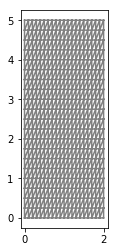

In [46]:
originx = 0.0
originy = 0.0
cornerx = 2.0
cornery = 5.0

mesh = RectangleMesh(Point(originx,originy), Point(cornerx,cornery), 20, 20)


plot(mesh)
plt.show()

In [47]:
# define function that describes the heat generation of the battery 
def q(u) : 
    I = 2 # current of the battery (Amps)
    Vol = 8 # volume of the battery (cm^2)
    R = 100 # Internal Resistance of the battery (Ohms)
    V = 0.60 # coefficient voltage variation with temperatur in battery cell
    return (I/Vol)*(I*R + V*u)

#convert expressions for u and f into c++ code
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y
f = - sym.diff(q(u)*sym.diff(u, x), x) - sym.diff(q(u)*sym.diff(u, y), y)
f = sym.simplify(f)
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)
print('u =', u_code)
print('f =', f_code)

In [48]:
V = FunctionSpace(mesh, 'P', 1)
gD = Constant(1.0) # top and bottom of battery are exposed to ambient temperature

u_int = Constant(1.0) # begin at same temp as outside
u0 = interpolate(u_int, V)

In [49]:
# defining parts of the boundaries by creating classes
class Left (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], originx)
class Right (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], cornerx)
class Bottom (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], originy)
class Top (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], cornery)

#create each instance of the classess created above
left = Left()
right = Right()
top = Top()
bottom = Bottom()

# Initialize mesh function for boundary domains and mark
boundaries = MeshFunction("size_t", mesh , 1) #
boundaries.set_all(0) #

left.mark(boundaries , 1)
top.mark(boundaries , 2)
right.mark(boundaries , 3)
bottom.mark(boundaries , 4)

ds = Measure("ds", domain = mesh, subdomain_data = boundaries) #

In [50]:
gN_left = Constant(100)
gN_right = Constant(100)

#declare neumann for top and bottom boundaries if necessary.
#gN_top = Constant(50)
#gN_bottom = Constant(50)

bc = DirichletBC(V, gD, boundaries, 2)

#define time interval and step size
num_steps = 1000
T = 10.0
dt = T/num_steps
t = 0

In [51]:
#variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('sin(x[0] + x[1])', degree = 2)#Constant(1.0)
#f = Expression('(I/Vol)*(I*R + V*u)', I = I, Vol = Vol, R = R, Volt = Volt, u = u degree = 1) # This is where the heat source will go (q) function of Temp.

In [52]:
up = u0 #store u(t=0) in new var

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u0 + dt*f)*v*dx - dt*gN_left*v*ds(1) - dt*gN_right*v*ds(3) # - dt*gN_top*v*ds(2) - dt*gN_bottom*v*ds(4) # end 

a = lhs(F) #left hand side
L = rhs(F) #right hand side

A = assemble(a)
u = Function(V)

In [53]:
vtkfile = File('solutions/battery_start.pvd')

In [54]:
# time travel
for n in range(num_steps) :
    t += dt
    
    print("t = ", t)
    
    b = assemble(L)
    bc.apply(A,b)
    solve(A, u.vector(), b)
    #solve(a == L, u, bcs)
    
    n = FacetNormal(mesh)
    
    # compute the power transfer through each boundary
    
    flux = inner(grad(u0), n)*ds(4) #flux through bottom 
    power_bottom = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(2) #flux through top boundary
    power_top = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(3) #flux through right boundary
    power_right = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(1) #flux through left boundary
    power_left = assemble(flux) #integrate flux to get power
    
    #update
    up.assign(u)
    vtkfile << (u,t) #save

t =  0.01
t =  0.02
t =  0.03
t =  0.04
t =  0.05
t =  0.060000000000000005
t =  0.07
t =  0.08
t =  0.09
t =  0.09999999999999999
t =  0.10999999999999999
t =  0.11999999999999998
t =  0.12999999999999998
t =  0.13999999999999999
t =  0.15
t =  0.16
t =  0.17
t =  0.18000000000000002
t =  0.19000000000000003
t =  0.20000000000000004
t =  0.21000000000000005
t =  0.22000000000000006
t =  0.23000000000000007
t =  0.24000000000000007
t =  0.25000000000000006
t =  0.26000000000000006
t =  0.2700000000000001
t =  0.2800000000000001
t =  0.2900000000000001
t =  0.3000000000000001
t =  0.3100000000000001
t =  0.3200000000000001
t =  0.3300000000000001
t =  0.34000000000000014
t =  0.35000000000000014
t =  0.36000000000000015
t =  0.37000000000000016
t =  0.38000000000000017
t =  0.3900000000000002
t =  0.4000000000000002
t =  0.4100000000000002
t =  0.4200000000000002
t =  0.4300000000000002
t =  0.4400000000000002
t =  0.45000000000000023
t =  0.46000000000000024
t =  0.47000000000000025
t 

t =  3.5799999999999677
t =  3.5899999999999674
t =  3.5999999999999672
t =  3.609999999999967
t =  3.619999999999967
t =  3.6299999999999666
t =  3.6399999999999664
t =  3.649999999999966
t =  3.659999999999966
t =  3.6699999999999657
t =  3.6799999999999655
t =  3.6899999999999653
t =  3.699999999999965
t =  3.709999999999965
t =  3.7199999999999647
t =  3.7299999999999645
t =  3.7399999999999642
t =  3.749999999999964
t =  3.759999999999964
t =  3.7699999999999636
t =  3.7799999999999634
t =  3.789999999999963
t =  3.799999999999963
t =  3.8099999999999627
t =  3.8199999999999625
t =  3.8299999999999623
t =  3.839999999999962
t =  3.849999999999962
t =  3.8599999999999617
t =  3.8699999999999615
t =  3.8799999999999613
t =  3.889999999999961
t =  3.899999999999961
t =  3.9099999999999606
t =  3.9199999999999604
t =  3.92999999999996
t =  3.93999999999996
t =  3.9499999999999598
t =  3.9599999999999596
t =  3.9699999999999593
t =  3.979999999999959
t =  3.989999999999959
t =  3.99999

t =  7.149999999999892
t =  7.159999999999892
t =  7.169999999999892
t =  7.179999999999891
t =  7.189999999999891
t =  7.199999999999891
t =  7.209999999999891
t =  7.2199999999998905
t =  7.22999999999989
t =  7.23999999999989
t =  7.24999999999989
t =  7.25999999999989
t =  7.269999999999889
t =  7.279999999999889
t =  7.289999999999889
t =  7.299999999999889
t =  7.309999999999889
t =  7.319999999999888
t =  7.329999999999888
t =  7.339999999999888
t =  7.349999999999888
t =  7.3599999999998875
t =  7.369999999999887
t =  7.379999999999887
t =  7.389999999999887
t =  7.399999999999887
t =  7.4099999999998865
t =  7.419999999999886
t =  7.429999999999886
t =  7.439999999999886
t =  7.449999999999886
t =  7.459999999999885
t =  7.469999999999885
t =  7.479999999999885
t =  7.489999999999885
t =  7.4999999999998845
t =  7.509999999999884
t =  7.519999999999884
t =  7.529999999999884
t =  7.539999999999884
t =  7.5499999999998835
t =  7.559999999999883
t =  7.569999999999883
t =  7.579

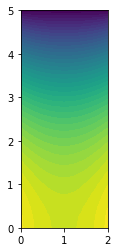

In [55]:
plot(u)
plt.show()

In [56]:
print("The power transfer through the bottom boundary is {}".format(power_bottom), "Joules")
print("The power transfer through the top boundary is {}".format(power_top), "Joules")
print("The power transfer through the right boundary is {}".format(power_right), "Joules")
print("The power transfer through the left boundary is {}".format(power_left), "Joules")

The power transfer through the bottom boundary is 13.347877097957733 Joules
The power transfer through the top boundary is -671.6997219835335 Joules
The power transfer through the right boundary is 470.6633772700756 Joules
The power transfer through the left boundary is 447.0237976423275 Joules
